In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import numpy as np
import axelrod as axl  # https://axelrod.readthedocs.io/en/stable/index.html
from time import time
from pprint import pprint
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

# the following imports are from network / axl_utils folder
import network
from axl_utils import NNplayer, State, set_match, set_play

In [3]:
C = axl.Action.C
D = axl.Action.D

# config game rules
# set_match & set_play function could be found inside axl_utils/game.py
GAME_LEN = 20 + 1
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

In [4]:
# the play function set up match between 2 players, print the result then return the match object
game = play(axl.Prober4(), axl.TitForTat())
game

[(3, 3), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (1, 1), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (0, 5), (5, 0)]
Player 1 score = 50
Player 2 score = 45


### Section 0: data

In [14]:
# an brief intro to the data

# State class could be found under axl_utils/nnplayer.py
# create a state container by
state = State(GAME_LEN)

# this creates a empty state that looks like this
current_state = state.values()
print("(1) current state")
print(current_state)
# '1' represent cooperation
# '0.1' represent defection
# '-1' means the turn has not happened yet

# assume we have a interaction between players, where one cooperated, and the other defected
# and the action would thus be C
# reward = 0 
action = C
reward = 0  # from payoff matrix
# to record this into the state:
state.push(C, D)

# updated state looks like this
next_state = state.values()
print("\n(2) next state")
print(next_state)
# New interactions are pushed to the *END* of the array
# this way the latest interaction is always fixed on the same positioin
# I hope this would help our algorithm to learn tit-for-tat


# Transition records what occured in the game, for our neural network to learn
# a Transition = (current_state, action, next_state, reward)
# so this transition would be
from network.dqn import Transition
transition = Transition(current_state, action, next_state, reward)
print("\n(3) Transition")
print(transition)
# these form the data in this project


# a ReplayMemory is just a container to store the Transitions and feed to our neural network
memory = network.ReplayMemory(2)  # <- control the size
[memory.push(*transition) for i in '1234'];
print("\n(4) Memory")
print(memory)

del memory, transition, Transition, current_state, action, next_state, reward

(1) current state
[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]]

(2) next state
[[[-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.   1. ]
  [-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.  -1.   0.1]]]

(3) Transition
Transition(state=array([[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1]]]), action=C, next_state=array([[[-1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
         -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
          1. ],
        [-1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
         -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
          0.1]]]), reward=0)

(4) Memory
deque([Tra

### Section 1: DQN

In [6]:
# DQN class is inside network/dqn.py
# it defines how the network make decision + how it learns

dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)

# NNplayer class is inside axl_utils/nnplayer.py
# it integrates our DQN with the axl library
# to allow it play under axl's environment

p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [7]:
# 'with' statement makes my DQN enter test mode
# where its episilon-greedy is set to 0 (no random exploration)
# + printing our the estimated Q-value

with p1:
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
    
# initial Q_value predictions:

[[ 0.817 -0.064]]
[[ 0.533 -0.691]]
[[-0.288 -0.615]]
[[-0.24   0.249]]
[[-0.65 -0.06]]
[[-0.448  1.126]]
[[-0.088  1.109]]
[[-0.618  2.344]]
[[-1.412  1.524]]
[[-1.527  0.956]]
[[-1.007  1.236]]
[[-0.33  -0.227]]
[[-0.198  0.139]]
[[-0.583  0.329]]
[[-1.128  0.14 ]]
[[0.111 0.13 ]]
[[ 0.427 -0.592]]
[[ 0.185 -0.195]]
[[-0.468 -0.758]]
[[-0.36   0.263]]
[[-0.725 -0.663]]


In [8]:
# initial experience
# high greedy -> more random exploration

p1.set_greedy(0.8)
for i in range(60):
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
p1.set_greedy(0.2)

In [9]:
# theoritical Q values
# assuming the player cooperate til the last turn, then defect
# apply annuity formula with cashflow = 3.0, interest rate = 1/9, periods = 20 turns
# * the (1/9) come from our hyperparameter gamma, which is set to 0.9 by default
# then compensate the defection in 2nd last turn, and hard code the last turn to 0.0
true_Q = np.array([3.0/(1/9) * (1.0 - 1.0/(1.0+1/9)**(19-i)) + 5.0 if i<20 else 0.0 for i in range(21)])
[print(f'{i:.2f}') for i in true_Q];

28.35
27.95
27.50
27.00
26.44
25.82
25.14
24.37
23.53
22.59
21.54
20.38
19.09
17.65
16.06
14.29
12.32
10.13
7.70
5.00
0.00


In [10]:
# training loop

score_ls = []
errors = []
for _ in range(20):
    start = time()
    
    # calling train method bound to NNplayer/DQN class
    # detailed documentation are there
    p1.train(30, param)
    
    # collect new experience with trained network
    [Match((p1, axl.TitForTat())).play() for _ in range(10)]
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # calculating Q-value error for later use
    # a bit tedious here but I'm too lazy to fix
    values = []
    state = State(21)
    for i in range(21):
        value = p1.network(state.values())[0]
        if i != 19:
            values.append(value[0])
        else:
            values.append(value[1])  # defection on last turn
        state.push(C, C) 
    error = true_Q - np.array(values)
    errors.append(error)


# left: running loss for cooperation
# right: running loss for defection

loss: [0.313 0.334],            time: +3.76 sec
loss: [0.198 0.169],            time: +4.62 sec
loss: [0.134 0.143],            time: +4.82 sec
loss: [0.087 0.108],            time: +5.67 sec
loss: [0.076 0.076],            time: +7.17 sec
loss: [0.058 0.066],            time: +5.85 sec
loss: [0.042 0.043],            time: +6.36 sec
loss: [0.034 0.04 ],            time: +6.78 sec
loss: [0.031 0.032],            time: +6.25 sec
loss: [0.034 0.04 ],            time: +6.10 sec
loss: [0.032 0.037],            time: +6.04 sec
loss: [0.028 0.038],            time: +5.59 sec
loss: [0.024 0.031],            time: +6.30 sec
loss: [0.026 0.035],            time: +6.08 sec
loss: [0.023 0.037],            time: +5.55 sec
loss: [0.025 0.032],            time: +6.49 sec
loss: [0.023 0.025],            time: +6.65 sec
loss: [0.023 0.026],            time: +6.23 sec
loss: [0.018 0.033],            time: +5.90 sec
loss: [0.023 0.03 ],            time: +5.64 sec


In [11]:
with p1:
    play(p1, axl.TitForTat())
# predicted Q-values after training:

[[26.374 25.718]]
[[25.852 25.278]]
[[25.567 25.016]]
[[25.243 24.599]]
[[24.75  24.112]]
[[24.133 23.426]]
[[23.552 22.755]]
[[22.862 22.157]]
[[22.079 21.316]]
[[21.277 20.576]]
[[20.253 19.516]]
[[19.228 18.51 ]]
[[18.022 17.307]]
[[16.752 16.101]]
[[15.264 14.512]]
[[13.562 12.834]]
[[11.78  11.053]]
[[9.786 9.1  ]]
[[7.559 5.892]]
[[2.799 5.029]]
[[-0.001  0.015]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


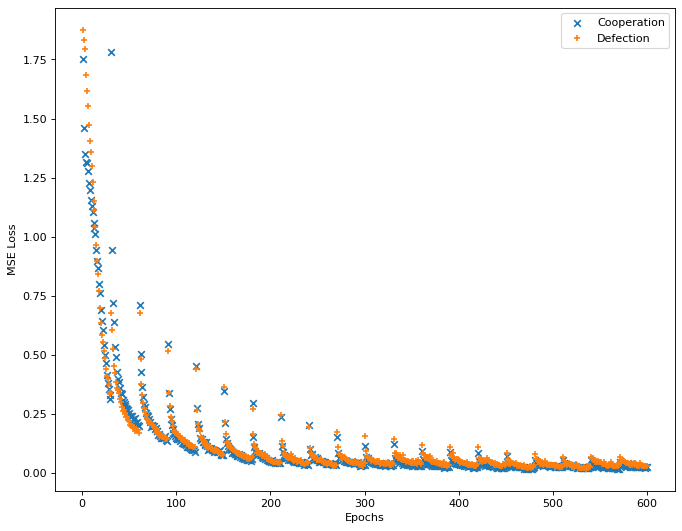

In [12]:
# training loss
# the beauty of double DQN
p1.plot()

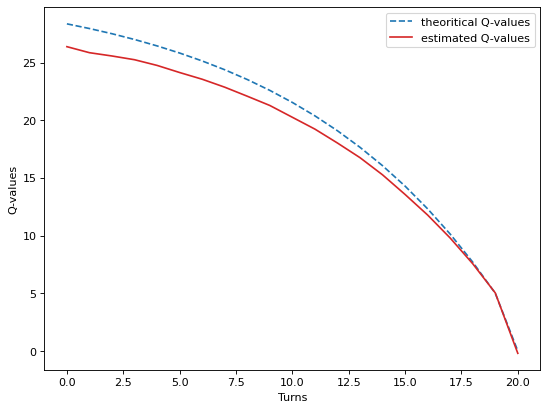

In [13]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(range(21), true_Q, '--', c='tab:blue', label='theoritical Q-values')
plt.plot(range(21), values, c='tab:red', label='estimated Q-values')
plt.xlabel('Turns')
plt.ylabel('Q-values')
plt.legend(loc='upper right')
plt.show()

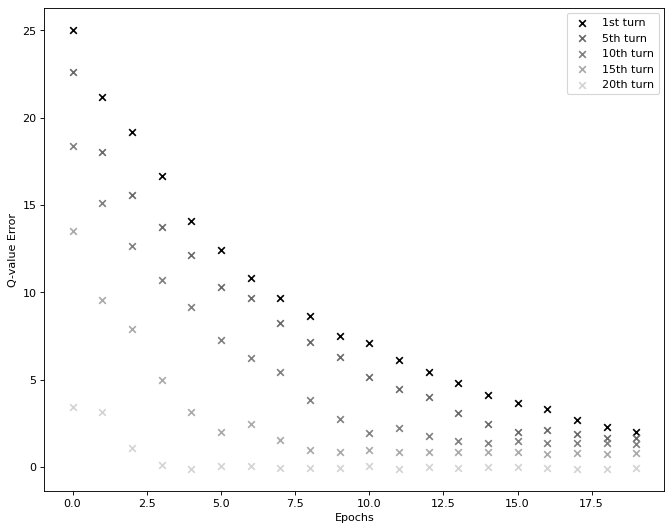

In [14]:
# visualizing the recursion nature of Bellman's equation,
# where the later states has to be learnt prior to learning preceding states

# plotting the error between our prediction against the theoritical Q-value
errors = np.array(errors)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(range(len(errors)), errors[:,0], c='black', marker='x', label='1st turn')
plt.scatter(range(len(errors)), errors[:,4], c='dimgrey', marker='x', label='5th turn')
plt.scatter(range(len(errors)), errors[:,9], c='grey', marker='x', label='10th turn')
plt.scatter(range(len(errors)), errors[:,14], c='darkgrey', marker='x', label='15th turn')
plt.scatter(range(len(errors)), errors[:,19], c='lightgrey', marker='x', label='20th turn')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Q-value Error')
plt.show()

# due to the recursion
# V(current) is dependent on V(next)
# meaning that 1st turn will not be correctly learnt until 2nd got the right value
# resulting in the gaps below

# this is similar to how tabular Q learning works via dynamic programming

### Section 2: DQN without fixed target (single DQN)

In [15]:
dqn2 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)
p2 = NNplayer(dqn2, State(GAME_LEN))
del dqn2
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

p2.set_greedy(0.8)
for i in range(60):
    players = (p2, axl.TitForTat())
    game = Match(players)
    game.play()
p2.set_greedy(0.2)

for _ in range(100):
    start = time()
    
    p2.train(1, param)  # my train function updates target net at the end via deepcopy, we can overwrite this by
    p2.network.target_net = p2.network.policy_net  # shallow copy policy net to target net
    
    [Match((p2, axl.TitForTat())).play() for _ in range(10)]
    print(f'loss: {p2.network.loss},            time: +{time()-start:.2f} sec')

loss: [2.114 1.832],            time: +0.40 sec
loss: [2.933 2.208],            time: +0.43 sec
loss: [2.886 2.019],            time: +0.44 sec
loss: [2.528 2.031],            time: +0.50 sec
loss: [2.419 2.1  ],            time: +0.46 sec
loss: [2.477 2.171],            time: +0.52 sec
loss: [2.343 2.268],            time: +0.47 sec
loss: [2.728 2.472],            time: +0.48 sec
loss: [2.291 2.641],            time: +0.47 sec
loss: [2.831 2.925],            time: +0.46 sec
loss: [2.856 3.166],            time: +0.45 sec
loss: [3.12  3.722],            time: +0.54 sec
loss: [3.327 4.022],            time: +0.50 sec
loss: [3.589 4.468],            time: +0.52 sec
loss: [3.859 5.213],            time: +0.46 sec
loss: [4.039 5.96 ],            time: +0.48 sec
loss: [4.275 6.591],            time: +0.53 sec
loss: [4.756 7.587],            time: +0.49 sec
loss: [5.356 8.249],            time: +0.51 sec
loss: [6.176 9.012],            time: +0.44 sec
loss: [6.875 9.857],            time: +0

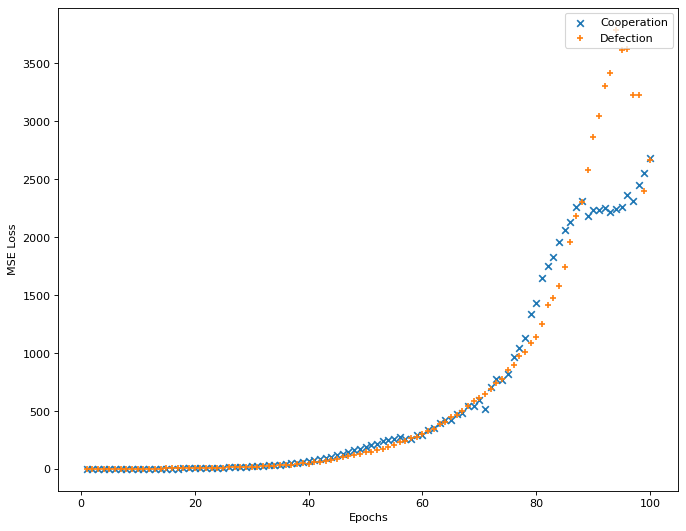

In [16]:
# see how loss grows exponentially without fixed target
p2.plot()

In [17]:
# result:
with p2:
    play(p2, axl.TitForTat())
    
# incorrect Q-values -> bad/random policy
# (run this section serveral time to see how the policy is effectively random)

[[3097.326 2613.673]]
[[5736.065 5182.708]]
[[-1125.962 -1521.474]]
[[4107.724 3486.16 ]]
[[6306.712 5605.391]]
[[-1252.292 -1719.868]]
[[2399.26  1765.281]]
[[3065.007 2381.196]]
[[2058.152 1352.007]]
[[ -897.301 -1463.329]]
[[2132.314 1414.995]]
[[2370.267 1643.727]]
[[3550.831 2821.086]]
[[ 457.242 -151.695]]
[[1124.796  532.58 ]]
[[2975.576 2382.679]]
[[498.029   8.526]]
[[1302.382  846.888]]
[[-339.873 -680.261]]
[[847.798 548.672]]
[[-566.197 -741.781]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Player 1 score = 60
Player 2 score = 60


In [18]:
del p2

### Section 3: testing the off-policyness

In [19]:
from axl_utils.extract import extract

In [20]:
# collecting experience from axl.Random
memory = network.ReplayMemory(10000)
for _ in range(500):
    game = play(axl.Random(), axl.TitForTat(), show=False)
    extract(game, memory)
    
print(len(memory))
# we can then pass this memory into a fresh DQN

10000


In [21]:
dqn3 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            memory, gamma=0.9, greedy=0.2)  # <- feeding the memory from axl.Random
p3 = NNplayer(dqn3, State(GAME_LEN))
del dqn3
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [22]:
for _ in range(20):
    start = time()
    p3.train(5, param)
    print(f'loss: {p3.network.loss},            time: +{time()-start:.2f} sec')

loss: [0.274 0.297],            time: +4.57 sec
loss: [0.219 0.234],            time: +5.15 sec
loss: [0.185 0.202],            time: +4.46 sec
loss: [0.154 0.161],            time: +4.87 sec
loss: [0.134 0.147],            time: +6.02 sec
loss: [0.131 0.133],            time: +5.27 sec
loss: [0.117 0.124],            time: +4.96 sec
loss: [0.101 0.114],            time: +6.69 sec
loss: [0.102 0.104],            time: +6.02 sec
loss: [0.093 0.104],            time: +5.16 sec
loss: [0.092 0.099],            time: +5.04 sec
loss: [0.099 0.088],            time: +5.14 sec
loss: [0.071 0.088],            time: +6.16 sec
loss: [0.074 0.077],            time: +5.43 sec
loss: [0.07  0.078],            time: +5.56 sec
loss: [0.063 0.069],            time: +4.96 sec
loss: [0.063 0.075],            time: +5.47 sec
loss: [0.058 0.066],            time: +6.76 sec
loss: [0.058 0.064],            time: +5.25 sec
loss: [0.063 0.056],            time: +5.82 sec


In [23]:
with p3:
    play(p3, axl.TitForTat())
    
# learns well, without ever playing the game

[[26.647 25.927]]
[[26.141 25.402]]
[[25.572 24.86 ]]
[[25.048 24.334]]
[[24.461 23.764]]
[[23.857 23.166]]
[[23.192 22.542]]
[[22.427 21.724]]
[[21.787 21.07 ]]
[[20.916 20.382]]
[[19.992 19.398]]
[[18.829 18.147]]
[[17.426 16.626]]
[[16.108 15.447]]
[[14.891 14.023]]
[[13.36  12.753]]
[[11.284 10.862]]
[[9.597 9.169]]
[[7.492 6.284]]
[[2.925 4.919]]
[[0.293 0.038]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (5, 0)]
Player 1 score = 62
Player 2 score = 57


In [24]:
del p3

### Section 4: but what did it learn?

In [25]:
# might be an obvious question but let's see what happens if our DQN meets provocative defection

p1.network.greedy = 0.0
play(p1, axl.HardProber());  # hard prober defects forever if its opponent does not retaliate

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (1, 1)]
Player 1 score = 7
Player 2 score = 92


In [26]:
play(axl.Cooperator(), axl.HardProber());  # => our DQN is basically a naive cooperator

[(0, 5), (0, 5), (3, 3), (3, 3), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5)]
Player 1 score = 6
Player 2 score = 96


In [27]:
play(axl.TitForTat(), axl.HardProber());  # while TFT can generalize well to any opponent

[(0, 5), (1, 1), (5, 0), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Player 1 score = 57
Player 2 score = 57


In [28]:
# => continue exploration on Stage 2

### Section 5: learning TFT with 2 perceptrons

In [29]:
# possible states of last turn
# where [1,1] means mutual cooperation
last_turn = np.array([[1,1],[0,1],[1,0],[0,0]])

# target
# => copy opponent's action
action = np.array([[1],[1],[0],[0]])

nn = network.NeuralNetwork([network.Linear_layer(2, 1)])
param = {"lr": 3e-2, 'batch': 2, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [30]:
for i in range(40):
    nn.train(last_turn, action, param)
    action_ = np.round(nn(last_turn))
    accuracy = np.sum(action_==action) / len(action)
    print(f"Epoch {i}, Accuracy = {accuracy}")

Average loss = 0.577315, elapsed time = 0.00.
Epoch 0, Accuracy = 0.5
Average loss = 0.461369, elapsed time = 0.00.
Epoch 1, Accuracy = 0.5
Average loss = 0.338558, elapsed time = 0.00.
Epoch 2, Accuracy = 0.5
Average loss = 0.290008, elapsed time = 0.00.
Epoch 3, Accuracy = 0.5
Average loss = 0.224684, elapsed time = 0.00.
Epoch 4, Accuracy = 0.75
Average loss = 0.184917, elapsed time = 0.00.
Epoch 5, Accuracy = 0.75
Average loss = 0.162287, elapsed time = 0.00.
Epoch 6, Accuracy = 0.75
Average loss = 0.148244, elapsed time = 0.00.
Epoch 7, Accuracy = 0.75
Average loss = 0.143882, elapsed time = 0.00.
Epoch 8, Accuracy = 0.75
Average loss = 0.138592, elapsed time = 0.00.
Epoch 9, Accuracy = 0.75
Average loss = 0.132955, elapsed time = 0.00.
Epoch 10, Accuracy = 0.75
Average loss = 0.124107, elapsed time = 0.00.
Epoch 11, Accuracy = 0.75
Average loss = 0.112047, elapsed time = 0.00.
Epoch 12, Accuracy = 0.75
Average loss = 0.097148, elapsed time = 0.00.
Epoch 13, Accuracy = 1.0
Average

In [31]:
# but obviously this is human-learning instead of machine learning
# will the DQN figure this out by itself?

# also, this is more of a policy-gradient approach
# the regression nature of DQNs make it impossible to employ simple architecture